In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import cm
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from matplotlib import patches
import seaborn as sn
from scipy.spatial.distance import pdist
from sklearn.manifold import TSNE
from scipy.stats import friedmanchisquare, kruskal, binom_test
from sklearn.cluster import k_means
from sklearn.preprocessing import normalize 
import itertools
from adjustText import adjust_text
import multiprocessing as mp
import itertools
import upsetplot as up
#import cProfile #%%prun -s cumulative -q -l 15 -T prun0
np.set_printoptions(suppress=True)

##### Parameters

In [2]:
#tenxten.xlsx onehun_ten.xlsx fivexten.xlsx tenx1.xlsx
data_dir = "data/"
plot_dir = "plots/"
save_name = "2020_04_"
file_name = "finalmatrix05_18_2020.csv"
full_data = True
n0 = 4211
pe = 0.120287583118229
motif_join = '+'

## Load data

In [4]:
#experiment_ = pd.read_excel("/Users/brandonbrown/Downloads/without_BarcodeMatrix.xlsx")
data_dir = "data/"

def load_df(file, remove_cols=None, subset=None):
    """
    Loads excel file specified in `file` which is a string for the full path
    Excel should have column names as the first row (header)
    `remove_col` specifies the names of columns to remove (list, e.g. ["DLS"])
    `subset` specifies the names of columns to keep (drop others, e.g. 'LH', 'BLA', 'PFC', 'NAc'])
    """
    experiment_ = pd.read_csv(file,header=0) #pd.read_excel(file,header=0)
    print(experiment_.columns)
    df = experiment_
    #df.columns = colnames
    if remove_cols is not None:
        try:
            df = df.drop(columns=remove_cols)
        except Exception as e:
            print("!!! Error: Could not remove columns. Column not found in `remove_cols`")
    if subset is not None:
        try:
            df = df[subset] #limit, removes BNST and CeA
        except Exception as e:
            print("!!! Error: Could not subset columns. Column not found in `subset`")
    return df

"""
Change the file path:
"""
file_path = data_dir + file_name
if full_data:
    #Load full data set
    df = load_df(file_path, remove_cols=["DLS"],subset=None)
else:
    #Load special 4 regions:
    df = load_df(file_path, remove_cols=["DLS"],subset=['LH', 'BA', 'PFC', 'NAc'])

print("df shape: {}".format(df.shape))
print("DF Head:")
print(df.head())
print("Number of NAs:")
print(df.isnull().sum())
#PFC NAc LS DLS BNST LH BLA CeA  | CM11 - CM18

Index(['PFC', 'NAc', 'LS', 'BNST', 'LH', 'BA', 'CeA'], dtype='object')
!!! Error: Could not remove columns. Column not found in `remove_cols`
df shape: (2494, 7)
DF Head:
     PFC    NAc   LS   BNST     LH     BA    CeA
0  0.000  0.000  0.0  0.000  1.000  0.000  0.000
1  1.000  0.544  0.0  0.173  0.292  0.129  0.327
2  1.000  0.000  0.0  0.000  0.000  0.000  0.000
3  0.000  0.000  0.0  0.000  1.000  0.881  0.748
4  0.566  1.000  0.0  0.000  0.000  0.945  0.000
Number of NAs:
PFC     0
NAc     0
LS      0
BNST    0
LH      0
BA      0
CeA     0
dtype: int64


## K-means clustering

In [5]:
# Find optimal number of clusters
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = k_means(df.to_numpy(), n_clusters=k)
    #km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km[2])
len(Sum_of_squared_distances)

14

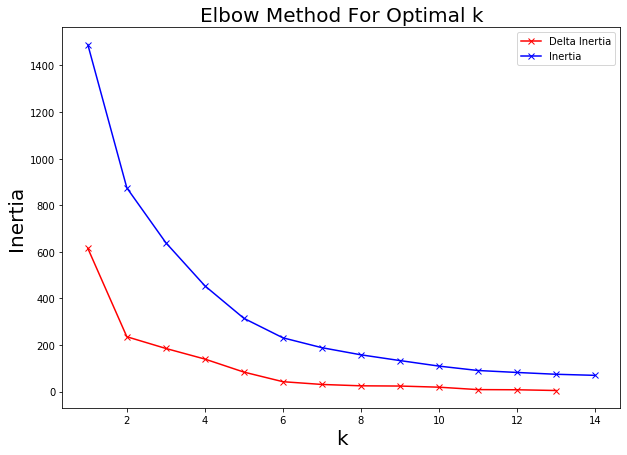

In [6]:
elbow_plt = plt.figure(figsize=(10,7))
s1 = np.array(Sum_of_squared_distances[0:-1])
s2 = np.array(Sum_of_squared_distances[1:])
plt.plot(K[0:-1], np.abs(s2-s1), 'bx-',c='red',label='Delta Inertia')
plt.plot(K, Sum_of_squared_distances, 'bx-',c='blue',label='Inertia')
plt.xlabel('k',fontsize=20)
plt.ylabel('Inertia',fontsize=20)
plt.title('Elbow Method For Optimal k',fontsize=20)
plt.legend()
#Looks like optimal cluster number is 6

In [10]:
elbow_plt.savefig(plot_dir + save_name + "elbow_plot.pdf")

#### Choose _k_

In [11]:
km = k_means(df.to_numpy(), n_clusters=6)
km[0].shape

(6, 7)

#### Plot clusters

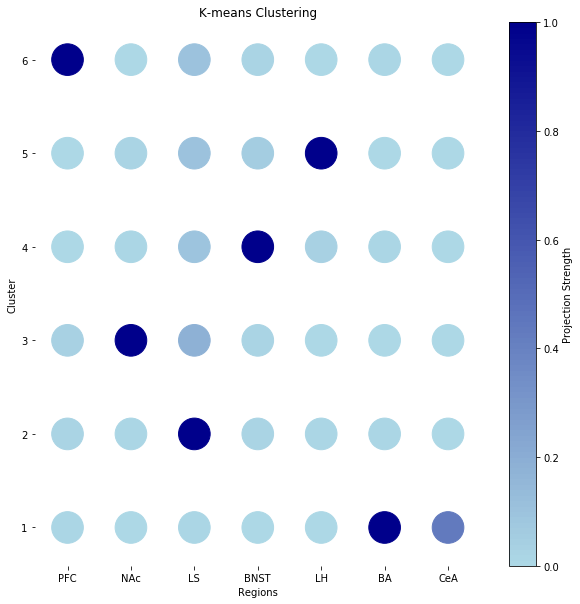

In [12]:
scolors = ['lightblue','darkblue']#['black','red','orange','yellow']#
scm = LinearSegmentedColormap.from_list(
        'white_to_red', scolors, N=100)
fig,ax = plt.subplots(nrows=1,ncols=1)
fig.set_size_inches(10,10)
clusters,regions = km[0].shape
ax.set_title("K-means Clustering")
ax.set_xlabel("Regions")
ax.set_ylabel("Cluster")
ax.set_xticks(range(regions))
ax.set_xticklabels(df.columns.to_list())
##
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
##
#g = np.linspace(0, 10, 1000)
#I = np.sin(g) * np.cos(g[:, np.newaxis])
#t = ax.imshow(I,cmap=scm,visible=False)
#fig.colorbar(mappable=t)
##
ax.set_yticks(range(0,clusters,1))
ax.set_yticklabels(range(1,clusters+1,1))
X = range(regions)
for i in range(km[0].shape[0]):
    y = np.array([i]).repeat(regions)
    #km[0][i]
    size = km[0][i]
    size = (size - size.min()) / (size.max() - size.min())
    ax_ = ax.scatter(x=X,y=y,s=1000,cmap=scm,c=size)

    #sn.regplot(x=X,y=y,ax=ax,scatter=False)
    #sn.scatterplot(x=X,y=y,ax=ax,size=size,legend=None,sizes=(100, 500),hue=size,palette=scm)
fig.colorbar(ax_,label='Projection Strength')

In [13]:
fig.savefig(plot_dir + save_name + "_kmeans.pdf")

## Count number of cells belonging to each motif
### Compare motif representation vs null model

In [14]:
def concatenate_list_data(slist,join=motif_join):
    result = []
    for i in slist:
        sub = ''
        for j in i:
            if sub:
                sub = sub + join + str(j)
            else:
                sub += str(j)
        result.append(sub)
    return result

In [15]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return itertools.chain.from_iterable(itertools.combinations(s, r) for r in range(len(s)+1))

In [16]:
def gen_motifs(r,labels): #r is number of regions, so number of motifis is 2^r
    num_motifs = 2**r
    motifs = np.zeros((num_motifs,r)).astype(np.bool)
    motif_ids = list(powerset(np.arange(r)))
    motif_labels = [] #list of labels e.g. PFC-LH or PFC-LS-BNST
    for i in range(num_motifs):
        idx = motif_ids[i]
        motifs[i,idx] = True
        #motif_labels.append(labels[[idx]].to_list())
        label = labels[np.array(idx)].to_list() if idx else ['']
        motif_labels.append(label)
    return motifs, motif_labels

In [17]:
def count_motifs(df,motifs,return_ids=False):
    """
    Returns a vector with counts that indicated number of motifs present for each possible motif
    A motif is a combination of target areas represented as a binary array, 
    e.g. [1,1,0] represents a motif where a cell targets the first two regions but not the 3rd
    A motif can be obtained by simply thresholding each cell's projection strength vector such that
    non-zero elements are 1.
    Also returns the labels for each motif
    """
    cells, regions = df.shape
    data = df.to_numpy().astype(bool)
    #np.unique(df.to_numpy().astype(bool),axis=0,return_counts=True)
    #if motifs is None: motifs = gen_motifs(regions)
    counts = np.zeros(motifs.shape[0])
    cell_ids = []
    for i in range(motifs.shape[0]): #loop through motifs (128x7)
        cell_ids_ = []
        for j in range(data.shape[0]): #loop through observed data cells X regions
            if np.array_equal(motifs[i],data[j]):
                counts[i] = counts[i] + 1
                cell_ids_.append(j)
        cell_ids.append(cell_ids_)
        
    if return_ids:
        return counts, cell_ids#, motifs
    else:
        return counts

In [18]:
def count_motifs_optim(df,motifs):
    """
    ** Optimized version
    Returns a vector with counts that indicated number of motifs present for each possible motif
    A motif is a combination of target areas represented as a binary array, 
    e.g. [1,1,0] represents a motif where a cell targets the first two regions but not the 3rd
    A motif can be obtained by simply thresholding each cell's projection strength vector such that
    non-zero elements are 1.
    Also returns the labels for each motif
    *optim version doesn't return cell_ids
    """
    cells, regions = df.shape
    data = df.to_numpy().astype(bool)
    #if motifs is None: motifs = gen_motifs(regions)
    counts = np.zeros(motifs.shape[0])
    for i in range(motifs.shape[0]): #loop through observed data cells X regions
        res = (motifs[i] == data).all(axis=1).nonzero() #tells which motif this cell is
        counts[i] = res[0].shape[0]
    return counts

#### Get motif counts for observed and synthesized data

In [19]:
def zip_with_scalar(l, o):
    return zip(l, itertools.repeat(o))

In [20]:
motifs, motif_labels = gen_motifs(df.shape[1],df.columns)

In [21]:
dcounts, cell_ids = count_motifs(df,motifs, return_ids=True) #observed data

In [22]:
def convert_counts_to_df(columns,counts,labels):
    """
    Deprecated. Use `get_obs_exp(...)` instead.
    
    Returns dataframe showing cell counts for each motif
    """
    motifdf = pd.DataFrame(columns=columns)
    for i in range(len(counts)):
        #other = {motif_labels[i][j]:1 for j in range(len(motif_labels[i]))}
        cols = labels[i]
        if len(cols) == 1 and not cols[0]:
            continue
        motifdf.loc[i,cols] = 1
        motifdf.loc[i,"Count"] = counts[i]
    return motifdf.fillna(0)

motif_df = convert_counts_to_df(df.columns,dcounts,motif_labels)

In [23]:
def get_expected_counts(motifs, num_regions = 7, prob_edge=pe,n=4211):
    #motif_set = set(['PFC', 'NAc', 'LS', 'BNST', 'LH', 'BA', 'CeA'])
    n_motifs = len(motifs)
    res = np.zeros(n_motifs)
    probs = np.zeros(n_motifs)
    for i,motif in enumerate(motifs):
        e1 = int(len(motif))
        e2 = num_regions - e1
        p = (prob_edge ** e1) * (1 - prob_edge) ** e2
        exp = float(p) * n
        res[i] = exp
        probs[i] = p
    res[0] = 0
    return res, probs

In [24]:
exp_counts, motif_probs = get_expected_counts(motif_labels)
df_obs_exp = pd.DataFrame(data=[concatenate_list_data(motif_labels),\
                                dcounts,\
                                exp_counts.astype(int)]).T
df_obs_exp.columns = ['Motif','Observed','Expected']
df_obs_exp.to_csv(plot_dir + save_name + "_motif_obs_exp.csv")
df_obs_exp

,Motif,Observed,Expected
0,,0,0
1,PFC,87,234
2,NAc,119,234
3,LS,1258,234
4,BNST,230,234
...,...,...,...
123,PFC+NAc+LS+LH+BA+CeA,0,0
124,PFC+NAc+BNST+LH+BA+CeA,1,0
125,PFC+LS+BNST+LH+BA+CeA,0,0
126,NAc+LS+BNST+LH+BA+CeA,0,0


## From motif counts, calculate p-values and effect size compared to null distribution

In [25]:
def standardize_pos(x):
    return (x + 1) / (x.std())
def standardize(x):
    return (x + 1e-13) / (x.max() - x.min())
def subset_list(lis, ids):
    return [lis[i] for i in ids]

##### Determining statistical signifance of projection motifs

In [26]:
def get_motif_sig_pts(dcounts,labels,\
                            prob_edge=0.120287583118229, n0 = 4211, \
                      exclude_zeros=True, \
                      p_transform=lambda x: -1 * np.log10(x)):
    #dcounts: motif counts from observed data
    num_motifs = dcounts.shape[0]
    expected, probs = get_expected_counts(labels, prob_edge=prob_edge,n=n0)
    assert dcounts.shape[0] == expected.shape[0]
    if exclude_zeros:
        nonzid = np.nonzero(dcounts)[0]
    else:
        nonzid = np.arange(dcounts.shape[0])
    num_nonzid_motifs = nonzid.shape[0]
    dcounts_ = dcounts[nonzid]
    expected_ = expected[nonzid]
    probs_ = probs[nonzid]
    #Effect size is log2(observed/expected)
    effect_size = np.log2((dcounts_ + 1) / (expected_ + 1))
    matches = np.zeros(num_nonzid_motifs)
    assert dcounts_.shape[0] == expected_.shape[0]
    for i in range(num_nonzid_motifs):
        pi = probs_[i] if probs_[i] > 0 else 1.0e-99
        matches[i] = binom_test(dcounts_[i],n=n0,p=pi)#alternative='greater'
        matches[i] = matches[i] if matches[i] > 0 else 1.0e-99
    matches = p_transform(matches)
    #matches is the significance level
    res = zip(effect_size, matches)
    mlabels = [labels[h] for h in nonzid]
    return list(res), mlabels

In [27]:
sigs, slabels = get_motif_sig_pts(dcounts,motif_labels,exclude_zeros=True)

In [28]:
#Bonferroni correction: p-threshold / Num comparisons
pcutoff = -1*np.log10(0.05 / len(slabels)) # = 3.1 for thresh of 0.05 or 3.6 for thresh of 0.01 for n=63

list_sig = [i for (i,(e,s)) in enumerate(sigs) if s > pcutoff ]
color_labels = ['gray' for i in range(len(sigs))]
for i in list_sig:
    e,s = sigs[i]
    if e > 0: #overrepresented
        color_labels[i] = 'red'
    else:
        color_labels[i] = 'blue'
#color_labels

## Plot motifs by statistical significance and effect size

160

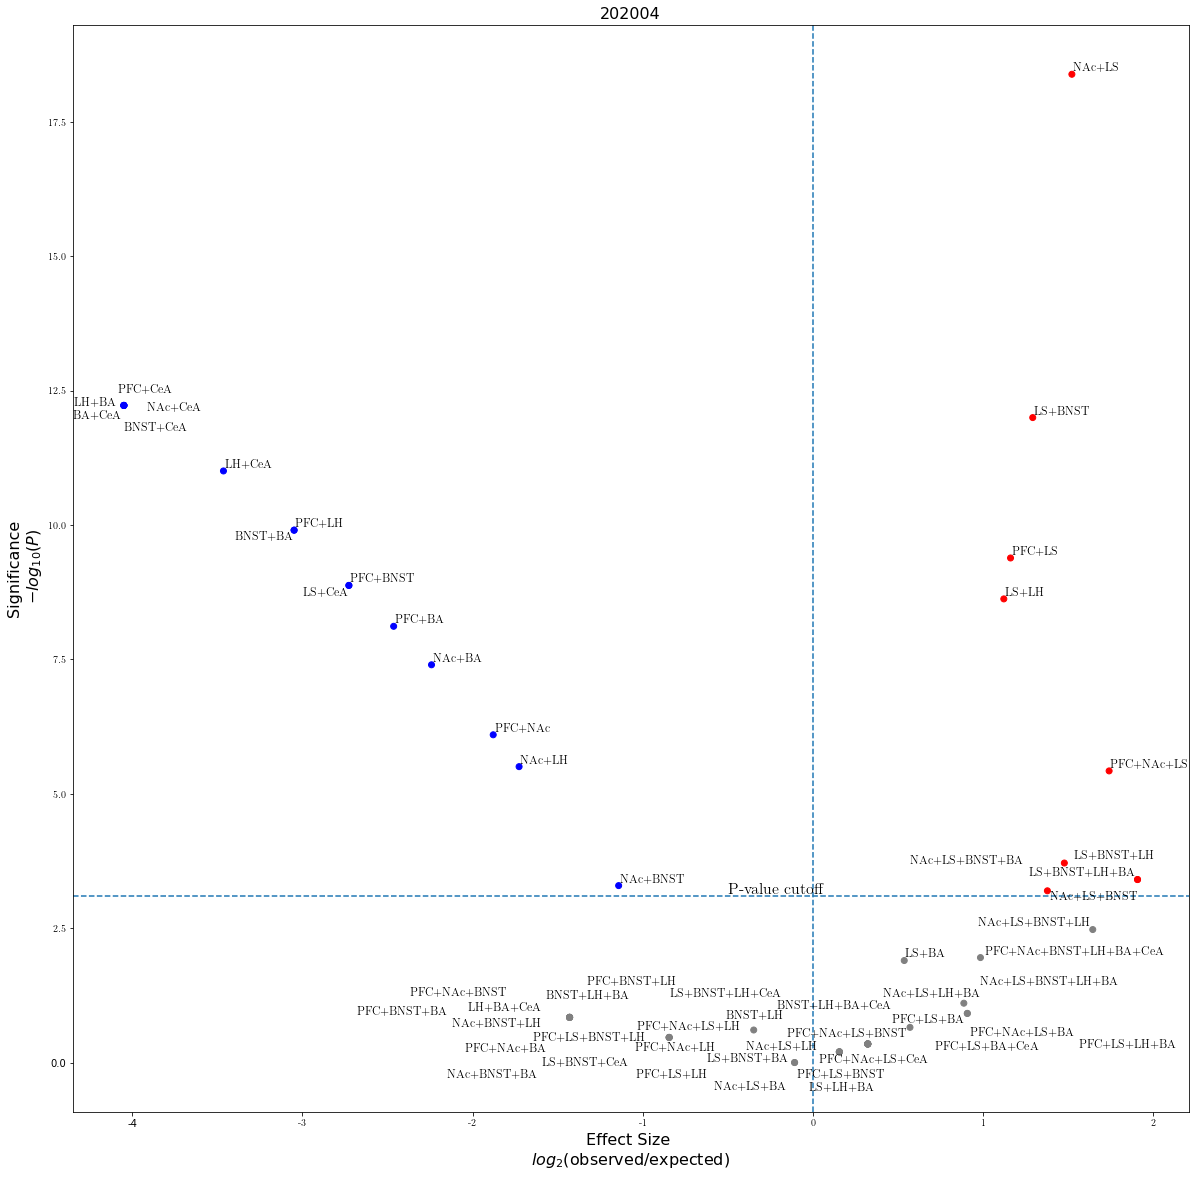

In [29]:
hide_singlets = True
if hide_singlets:
    mask = [i for (i,l) in enumerate(slabels) if len(l) > 1]
#subset_list(slabels,[1,5,7])
fig,ax = plt.subplots(1,1)#plt.figure(figsize=(13,11))
fig.set_size_inches(20,20)
#ax.set_ylim([0,5.5])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
ax.set_title(save_name.replace('_',''),fontsize=16)
ax.set_xlabel("Effect Size \n$log_2($observed/expected$)$",fontsize=16)
ax.set_ylabel("Significance\n $-log_{10}(P)$",fontsize=16)
ax.axhline(y=pcutoff, linestyle='--')
ax.axvline(x=0, linestyle='--')
ax.text(x=-.5,y=pcutoff+0.05,s='P-value cutoff',fontsize=16)
ax.scatter(*zip(*subset_list(sigs,mask)),c=subset_list(color_labels,mask))
pretty_slabels = concatenate_list_data(subset_list(slabels,mask))
texts = []
for n in range(len(subset_list(sigs,mask))): #for n in list_sig
    txt = pretty_slabels[n]
    z,y = subset_list(sigs,mask)[n]
    texts.append(ax.text(z,y,txt,fontsize=12))
adjust_text(texts) 
#plt.savefig(plot_dir + save_name + "_effect_significance_1000s.pdf")

In [30]:
fig.savefig(plot_dir + save_name + "_effect_significance.pdf")

### Plot individual cells' projection strengths for a given motif

In [31]:
#df[df.astype(bool)["PFC"] == True][df.astype(bool)["NAC"] == True]

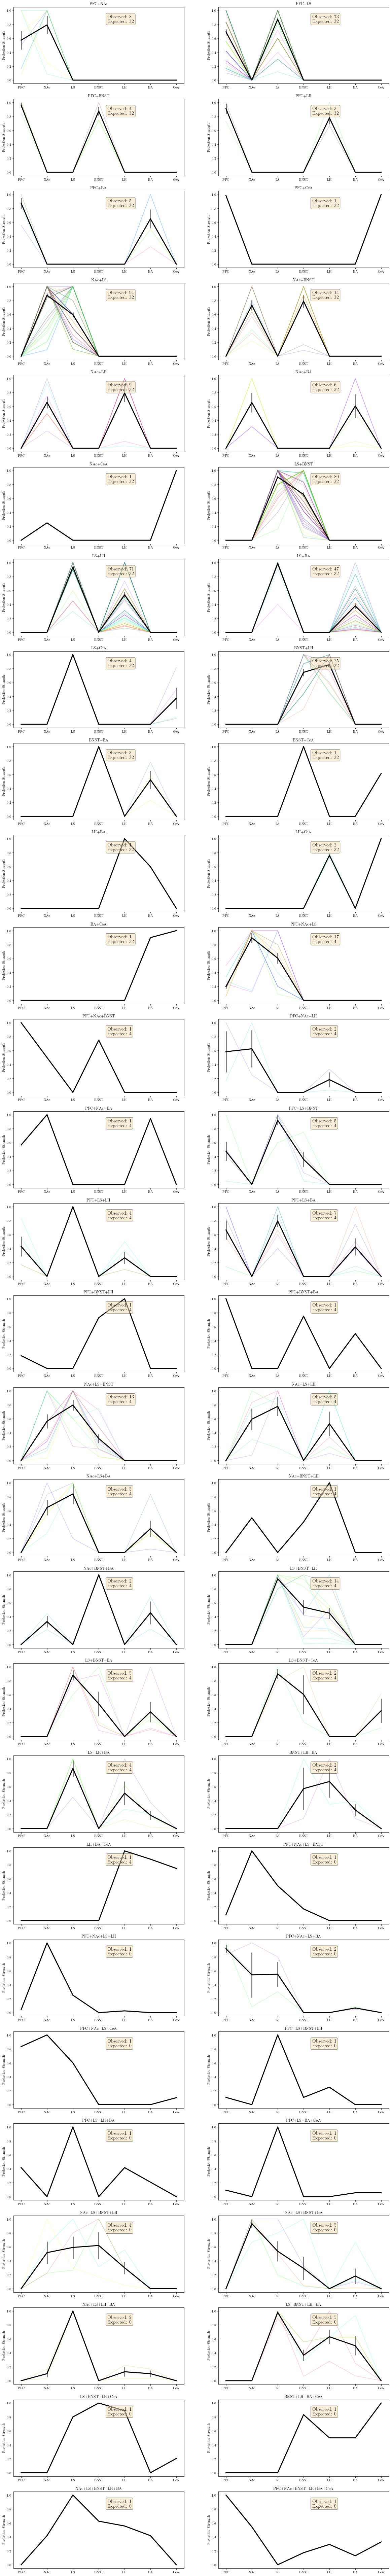

In [32]:
def gen_per_cell_plot(df,cell_ids,motif_labels,dcounts,expected,savepath=None, hide_singlets=True,figsize=(16,35)):
    """
    This plots each cell of a given motif on the same plot as an individual line
    Each line's points are the corresponding projection strengths at that region
    So this plot shows the projection strengths of all the cells for each motif
    """
    if hide_singlets: #Only show motifs with two or more regions
        mask = [i for (i,l) in enumerate(motif_labels) if len(l) > 1]
        cell_ids = subset_list(cell_ids,mask)
        
    non0cell_ids = [(i,x) for (i,x) in enumerate(cell_ids) if len(x) > 0]
    dcounts = subset_list(dcounts,mask)
    exp_counts_ = subset_list(expected,mask)
    obs_ex = []
    for i,x in non0cell_ids:
        oe = (dcounts[i],exp_counts_[i])
        obs_ex.append(oe)
    num_plots = len(non0cell_ids)
    plot_titles = concatenate_list_data(subset_list(motif_labels,mask))
    #print(num_plots)
    ncols = 2
    nrows = np.ceil(num_plots / ncols)
    fig = plt.figure(figsize=figsize)
    n = 1
    for cellids_ in non0cell_ids:
        """if n > 2:
            break"""
        i,cellids = cellids_
        ax = fig.add_subplot(nrows,ncols,n)
        title = plot_titles[i]
        ax.set_title(title)
        ax.set_xticks(np.arange(df.shape[0]))
        ax.set_xticklabels(df.columns.to_list())
        ax.set_ylabel("Projection Strength")
        #x = df[df.index.isin(cellids)].to_numpy()
        x = df.iloc[cellids,:].to_numpy()
        ## add observed/expected legend
        obs,ex = obs_ex[n-1]
        textstr = 'Observed: {} \n Expected: {}'.format(int(obs),int(ex))
        # these are matplotlib.patch.Patch properties
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        # place a text box in upper left in axes coords
        ax.text(0.55, 0.9, textstr, transform=ax.transAxes, fontsize=14,
                verticalalignment='top', bbox=props)
        ##
        yerr = x.std(axis=0) / np.sqrt(x.shape[0])
        #ax.errorbar(x=np.arange(df.shape[1]), y=x.mean(axis=0),yerr=yerr,ecolor='black') # mean with error bars
        for j in range(x.shape[0]):
            ax.plot(np.arange(df.shape[1]), x[j], markerfacecolor='none', alpha=0.2, c=cm.gist_rainbow(np.random.rand())) #c='gray'
        ax.errorbar(x=np.arange(df.shape[1]), y=x.mean(axis=0),yerr=yerr,ecolor='gray', c='black',linewidth=3) # mean with error bars
        n+=1
    if savepath:
        fig.savefig(savepath)
    return ax

#Run the function
if full_data:
    fig_size2 = (20,140) #(20,140)
else:
    fig_size2 = (20,10)
gprcpplot = gen_per_cell_plot(df,cell_ids,motif_labels,dcounts,exp_counts,figsize=fig_size2, savepath = plot_dir + save_name + "_per_cell_proj_strength.pdf")
#
#

In [33]:
def show_perc_motifs(perc=True):
    if perc:
        return list(zip(dcounts / (dcounts.sum() / 100),motif_labels))
    else:
        return list(zip(dcounts,motif_labels))

## Plot cluster heatmap of projections

In [34]:
colors = ['white','red']
#colors = ['white','blue']
'''cm = LinearSegmentedColormap.from_list(
        'white_to_red', colors, N=100)'''
cm = LinearSegmentedColormap.from_list(
        'white_to_red', colors, N=100)

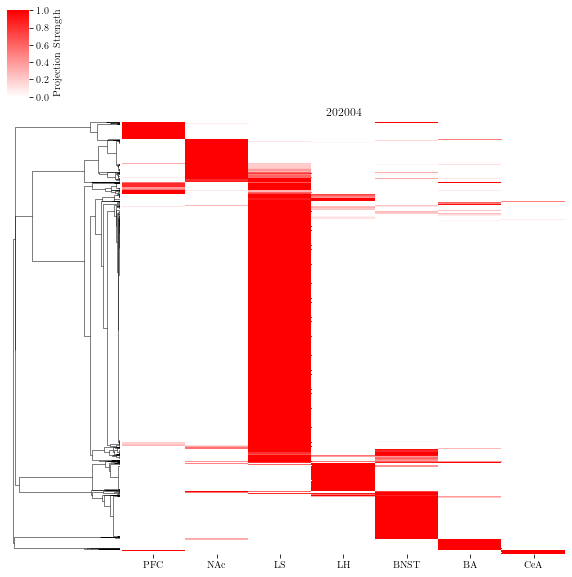

In [35]:
# Draw heatmap
sn.light_palette("#ef6e6e",n_colors=2,as_cmap=True)
order_full = reversed(['CeA','BA','BNST','LH','LS','NAc','PFC'])
order_partial = ['LH','BLA','NAc','PFC']
if full_data:
    #df_ = df[['PFC','LS','CEA','NAC','BLA','LH','BNST']]
    #df_ = df[reversed(['BLA', 'NAC','PFC','LS','BNST','LH','CEA'])]
    df_ = df[order_full]
else:
    df_ = df[order_partial]

clusterfig = sn.clustermap(df_,col_cluster=False,metric='cosine', method='average',\
              cbar_kws=dict(label='Projection Strength'), \
                cmap=cm,vmin=0.0,vmax=1.0)
clusterfig.ax_heatmap.set_title(save_name.replace('_',''))
clusterfig.ax_heatmap.axes.get_yaxis().set_visible(False)
#sn.heatmap(experiment,cbar_kws=dict(shrink=0.5,label='Projection Strength'))
#clusterfig.savefig("/Users/brandonbrown/Desktop/KheirbekLab/MAPseq/clustermap.pdf")

In [36]:
clusterfig.savefig(plot_dir + save_name + "_red_white_cluster_heatmap.pdf")

## Plot conditional probabilities of projection

Y-axis: Area B

X-axis: Area A

Values: $P(B\ |\ A)$ probability of projecting to B given projection to A 

How to calculcate...

$P(B\ |\ A)$ Of all the neurons that project to A, what proportion also project to B

In [37]:
def gen_prob_matrix(df : pd.DataFrame):
    data = df.to_numpy(copy=True)
    cells,regions = data.shape
    mat = np.zeros((regions,regions)) #area B x area A
    #loop over columns (region )
    for col in range(regions):
        #find all cells (rows in data) that project to 'col'
        ids_col = np.where(data[:,col] != 0)[0]
        sub_col = data[ids_col]
        #of these, how many project to region B
        for row in range(regions):
            ids_row = np.where(sub_col[:,row] != 0)[0]
            prob = ids_row.shape[0] / ids_col.shape[0]
            #print("P({} | {}) = {}".format(df.columns[row],df.columns[col],prob))
            mat[col,row] = prob
    mat = pd.DataFrame(mat, columns=df.columns)
    mat.index = df.columns
    return mat

In [38]:
probmat = gen_prob_matrix(df)

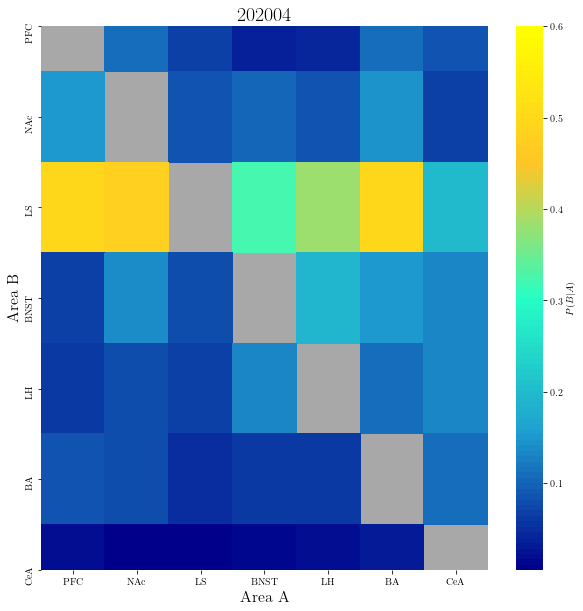

In [39]:
#P(BNST | LS) = 0.5
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title(save_name.replace('_',''),fontsize=20)
#colors2 = ['black','red','orange','yellow']
colors2 = ['darkblue','#1f9ed1','#26ffc5','#ffc526','yellow']
cm2 = LinearSegmentedColormap.from_list(
        'white_to_red', colors2, N=100)
ax.set_facecolor('#a8a8a8')
ax = sn.heatmap(probmat.T,mask=probmat.T == 1,ax=ax,cbar_kws=dict(label='$P(B | A)$'),cmap=cm2,vmax=0.6)
ax.set_xlabel("Area A",fontsize=16)
ax.set_ylabel("Area B",fontsize=16)
plt.savefig(plot_dir + save_name + "_blueyellow_probability_heatmap.pdf")

#### Get number of double projecting cells

In [40]:
#np.triu(probmat,k=1)[0].mean()

In [41]:
def remove_zero_rows(df):
    df_ = df.fillna(0)
    df = df.loc[~(df_==0).all(axis=1)].astype('float32')
    return df

In [42]:
def get_overlaps(df):
    """
    Returns the number of cells that target both regions in a pair
    """
    cells,regions = df.shape
    pairs = list(itertools.combinations(df.columns,2)) #remove null id
    pairs_unzip = list(zip(*pairs))
    from_r = list(pairs_unzip[0])
    to_r = list(pairs_unzip[1])
    counts=[]
    df = df.copy()
    for i in pairs:
        sub = df.T.loc[list(i)].T
        sub = remove_zero_rows(sub)
        counts.append(sub.shape[0])
    res = pd.DataFrame(columns=['from','to','value'])
    res['from'] = from_r
    res['to'] = to_r
    res['value'] = counts
    return res #counts, pairs

In [43]:
oo = get_overlaps(df)
oo.head()

,from,to,value
0,PFC,NAc,510
1,PFC,LS,1849
2,PFC,BNST,638
3,PFC,LH,515
4,PFC,BA,381


## Proportion of cells targeting specific regions

Want to know: given a motif, how many cells project to one or more of each region in the motif and of that total number of cells, what proportion project to all the cells in that motif

e.g. for length-2 motifs
LH-BLA = 117 / 2 = 1.71 %  
LH-PFC = 125 / 2 = 1.60 %  
LH-NAc = 162 / 8 = 4.94 %  
BLA-PFC = 46 / 0 = 0.0 %  
BLA-NAc = 83 / 4 = 4.82 %  
PFC-NAc = 91 / 2 = 2.20 %  
\# total / \# doublets  

In [44]:
def get_motif_count(motif,counts,labels):
    """
    Get the number of cells that project to this specific motif
    where `motif` is a list of column names e.g. ['LH','PFC']
    """
    for i in range(len(labels)):
        if set(motif) == set(labels[i]):
            return counts[i]

In [45]:
get_motif_count(['BNST','CeA'],dcounts,motif_labels)

1.0

In [46]:
import re
pattern = re.compile('([^\s\w]|_)+')

def strip_nonchars(string):
    strip = pattern.sub('', string)
    return strip

In [47]:
def findsubsets(S,m):
    return set(itertools.combinations(S, m))
#findsubsets(df.columns.to_list(),2)

#LH, PFC, BLA and NAc
def get_pair_reg_props(df,counts,labels):
    """
    Given each pair in region_list, find number of cells that target either in the pair
    and then find proportion of cells that target both in pair exclusively
    
    counts: motif counts
    labels: motif labels
    """
    region_list = df.columns.to_list()
    R = len(region_list)
    tot = df.shape[0] / 100
    pairs = findsubsets(region_list,2)
    results = []
    for i,pair in enumerate(pairs):
        p1,p2 = pair
        num_cells_p1 = df[df[p1] > 0.].shape[0]
        num_cells_p2 = df[df[p2] > 0.].shape[0]
        tot_cells = num_cells_p1 + num_cells_p2
        num_doublets = get_motif_count([p1,p2],counts,labels)
        perc = np.around((100.0 * num_doublets) / tot_cells,3)
        results.append((p1,p2,tot_cells,num_doublets,perc))
    return results

In [48]:
get_pair_reg_props(df,dcounts,motif_labels)

[('BNST', 'CeA', 470, 1.0, 0.213),
 ('NAc', 'LH', 616, 9.0, 1.461),
 ('LH', 'CeA', 346, 2.0, 0.578),
 ('PFC', 'BNST', 653, 4.0, 0.613),
 ('PFC', 'BA', 400, 5.0, 1.25),
 ('LS', 'BNST', 2158, 80.0, 3.707),
 ('PFC', 'CeA', 275, 1.0, 0.364),
 ('LH', 'BA', 471, 1.0, 0.212),
 ('LS', 'CeA', 1780, 4.0, 0.225),
 ('NAc', 'BA', 487, 6.0, 1.232),
 ('BNST', 'BA', 595, 3.0, 0.504),
 ('BNST', 'LH', 724, 25.0, 3.453),
 ('NAc', 'CeA', 362, 1.0, 0.276),
 ('LS', 'BA', 1905, 47.0, 2.467),
 ('PFC', 'NAc', 545, 8.0, 1.468),
 ('NAc', 'LS', 2050, 94.0, 4.585),
 ('NAc', 'BNST', 740, 14.0, 1.892),
 ('PFC', 'LH', 529, 3.0, 0.567),
 ('LS', 'LH', 2034, 71.0, 3.491),
 ('PFC', 'LS', 1963, 73.0, 3.719),
 ('BA', 'CeA', 217, 1.0, 0.461)]

In [49]:
def get_all_counts(df,motifs,counts,labels):
    """
    Returns an array where each row is a motif and the counts of 
    number of cells targeting each member of the motif (non-exclusive), total number of cells targeting any of 
    the members of the motif, number of cells targeting all members of motif, and percentage exclusively targeting full
    motif (relative to any member of the motif), e.g.
    columns: PFC BNST LS CeA Total Motif Perc
    row 1  : 10   20  30  NA  60    6     10%
    where NA means that region is not part of the motif
    
    Input: `df`; dataframe of normalized data, Num cells (N) x Num regions (R)
    `motifs` M (num motifs) x R binary matrix indicating which regions present in each motif (row)
    `counts` vector containg counts of cells that exclusively project to each matching motif/row in `motifs`
    `labels` string labels for regions that make each matching motif in `motifs`
    """
    ret = pd.DataFrame(columns=df.columns.to_list() + ['Total', 'Motif Num', 'Motif Perc'])
    num_cols = len(ret.columns.to_list())
    for i,motif in enumerate(motifs): #loop through motifs
        m = [index for (index,x) in enumerate(motif) if x]
        if len(m) < 1:
            continue
        sums = df.iloc[:,m].astype(bool).astype(int).sum().to_numpy()
        ap = np.zeros(num_cols)
        ap[:] = np.nan
        ap[m] = sums
        ap = ap.reshape(1,ap.shape[0])
        ap = pd.DataFrame(ap,columns=ret.columns)
        tot = ap.iloc[:,0:-3].dropna(axis=1).to_numpy().sum()
        ap.iloc[:,-3] = tot
        ap.iloc[:,-2] = counts[i]
        ap.iloc[:,-1] = 100.0 * (counts[i] / ap.iloc[:,-3])
        ret = ret.append(ap)
    return ret

In [50]:
def get_all_counts_nondf(df,motifs,counts,labels):
    """
    Returns an array where each row is a motif and the columns are the counts of 
    number of cells targeting each member of the motif (non-exclusive), total number of cells targeting any of 
    the members of the motif, number of cells targeting all members of motif, and percentage exclusively targeting full
    motif (relative to any member of the motif), e.g.
    columns: PFC BNST LS CeA Total Motif Perc
    row 1  : 10   20  30  NA  60    6     10%
    where NA means that region is not part of the motif
    
    Input: `df`; dataframe of normalized data, Num cells (N) x Num regions (R)
    `motifs` M (num motifs) x R binary matrix indicating which regions present in each motif (row)
    `counts` vector containg counts of cells that exclusively project to each matching motif/row in `motifs`
    `labels` string labels for regions that make each matching motif in `motifs`
    """
    retdf = [] #return list
    #each element is a list [Labels, R1 count, R2 count ... Rn count, Total Count, Motif Count, Motif Perc]
    for i,motif in enumerate(motifs): #loop through motifs
        m = [index for (index,x) in enumerate(motif) if x]
        row = list(np.zeros(1+len(m)+3)) #1 (labels) + num-regions-in-motifs + 3 (total,motif count,motif perc)
        if len(m) < 1:
            continue
        sums = df.iloc[:,m].astype(bool).astype(int).sum().to_numpy()
        row[0] = labels[i]
        row[1:len(m)+1] = sums
        tot = sums.sum()
        row[len(m)+1] = tot
        row[len(m)+2] = counts[i]
        row[len(m)+3] = 100.0 * (counts[i] / tot)
        retdf.append(row)
    return retdf

In [51]:
unstruct_counts = get_all_counts_nondf(df,motifs,dcounts,motif_labels)
#unstruct_counts

In [52]:
def write_motif_counts(path,counts):
    with open(path, 'w') as f:
        for item in counts:
            f.write("%s\n" % item)

write_motif_counts(plot_dir + save_name + '_counts.txt',unstruct_counts)

In [53]:
mdf = get_all_counts(df,motifs,dcounts,motif_labels)

In [54]:
mdf.head()

,PFC,NAc,LS,BNST,LH,BA,CeA,Total,Motif Num,Motif Perc
0,229.0,NaN,NaN,NaN,NaN,NaN,NaN,229.0,87.0,37.991266
0,NaN,316.0,NaN,NaN,NaN,NaN,NaN,316.0,119.0,37.658228
0,NaN,NaN,1734.0,NaN,NaN,NaN,NaN,1734.0,1258.0,72.549020
0,NaN,NaN,NaN,424.0,NaN,NaN,NaN,424.0,230.0,54.245283
0,NaN,NaN,NaN,NaN,300.0,NaN,NaN,300.0,137.0,45.666667


In [55]:
mdf.to_csv(plot_dir + save_name + "_motif_counts.csv")

Number total/inclusive for pair vs number exclusive to pair  
LH-BLA = 117 / 2 = 1.71 %  
LH-PFC = 125 / 2 = 1.60 %  
LH-NAc = 162 / 8 = 4.94 %  
BLA-PFC = 46 / 0 = 0.0 %  
BLA-NAc = 83 / 4 = 4.82 %  
PFC-NAc = 91 / 2 = 2.20 %   

In [56]:
show_perc_motifs(False)

[(0.0, ['']),
 (87.0, ['PFC']),
 (119.0, ['NAc']),
 (1258.0, ['LS']),
 (230.0, ['BNST']),
 (137.0, ['LH']),
 (61.0, ['BA']),
 (28.0, ['CeA']),
 (8.0, ['PFC', 'NAc']),
 (73.0, ['PFC', 'LS']),
 (4.0, ['PFC', 'BNST']),
 (3.0, ['PFC', 'LH']),
 (5.0, ['PFC', 'BA']),
 (1.0, ['PFC', 'CeA']),
 (94.0, ['NAc', 'LS']),
 (14.0, ['NAc', 'BNST']),
 (9.0, ['NAc', 'LH']),
 (6.0, ['NAc', 'BA']),
 (1.0, ['NAc', 'CeA']),
 (80.0, ['LS', 'BNST']),
 (71.0, ['LS', 'LH']),
 (47.0, ['LS', 'BA']),
 (4.0, ['LS', 'CeA']),
 (25.0, ['BNST', 'LH']),
 (3.0, ['BNST', 'BA']),
 (1.0, ['BNST', 'CeA']),
 (1.0, ['LH', 'BA']),
 (2.0, ['LH', 'CeA']),
 (1.0, ['BA', 'CeA']),
 (17.0, ['PFC', 'NAc', 'LS']),
 (1.0, ['PFC', 'NAc', 'BNST']),
 (2.0, ['PFC', 'NAc', 'LH']),
 (1.0, ['PFC', 'NAc', 'BA']),
 (0.0, ['PFC', 'NAc', 'CeA']),
 (5.0, ['PFC', 'LS', 'BNST']),
 (4.0, ['PFC', 'LS', 'LH']),
 (7.0, ['PFC', 'LS', 'BA']),
 (0.0, ['PFC', 'LS', 'CeA']),
 (1.0, ['PFC', 'BNST', 'LH']),
 (1.0, ['PFC', 'BNST', 'BA']),
 (0.0, ['PFC', 'BNST', 

## Proportion of cells with 1,2,3...N targets

In [57]:
def get_target_pie(df : pd.DataFrame):
    """
    For each cell (row), determine how many projections it makes
    """
    data = df.to_numpy(copy=True)
    cells,regions = data.shape
    res = []#np.zeros(regions)
    for cell in range(cells):
        num_targets = int(np.nonzero(data[cell])[0].shape[0])
        res.append(num_targets)
    ret = np.array(res)
    #ret = pd.DataFrame(ret)
    return ret

In [58]:
df_pie = get_target_pie(df)

In [59]:
g,c = np.unique(df_pie,return_counts=True)

In [60]:
c_row_names = ['1 target']
c_row_names += ["{} targets".format(i+2) for i in range(c.shape[0]-1)]
c = pd.DataFrame(c,columns=['# Cells'], index=c_row_names)
c_np = c.to_numpy(copy=True).flatten()
c.head()

,# Cells
1 target,1920
2 targets,453
3 targets,93
4 targets,26
5 targets,1


In [61]:
c.to_csv("plots/pie_chart_data.csv")

In [62]:
c_tot = c_np.sum()
c_tot

2494

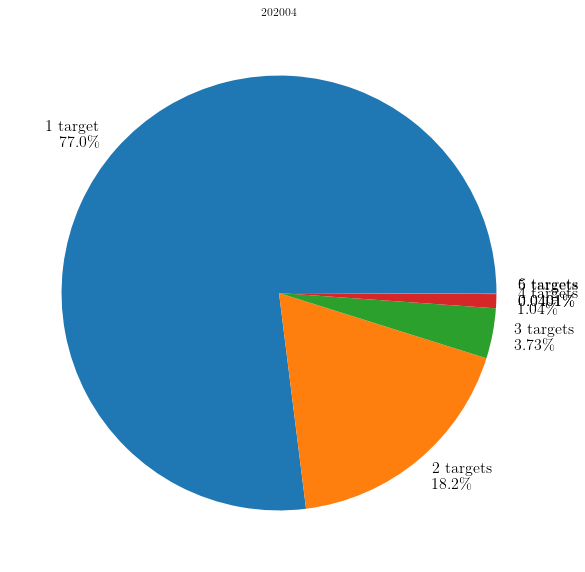

In [63]:
plt.figure(figsize=(10,10))
plt.title(save_name.replace('_',''))
glabels = ["1 target \n {:0.3}\%".format(100*c_np[0] / c_tot)]
glabels += ["{} targets \n {:0.3}\%".format(i+2,100*j/c_tot) for (i,j) in zip(range(c_np.shape[0]-1),c_np[1:])]
patches, texts = plt.pie(c.to_numpy().flatten(),labels=glabels)
[txt.set_fontsize(16) for txt in texts]
plt.savefig(plot_dir + save_name + "_num_targets_pie.pdf")

##  t-SNE dimensionality reduction for maximum projection

#### Plot cells by two tSNE components and colored by the region to which they maximally project

In [64]:
maxproj = TSNE(n_components=2,metric='cosine').fit_transform(df.to_numpy(copy=True))

In [65]:
#maxprojclusters = k_means(X=maxproj,n_clusters=6)

In [66]:
tlabels = df.to_numpy(copy=True).argmax(axis=1)
#tlabels = km[1]

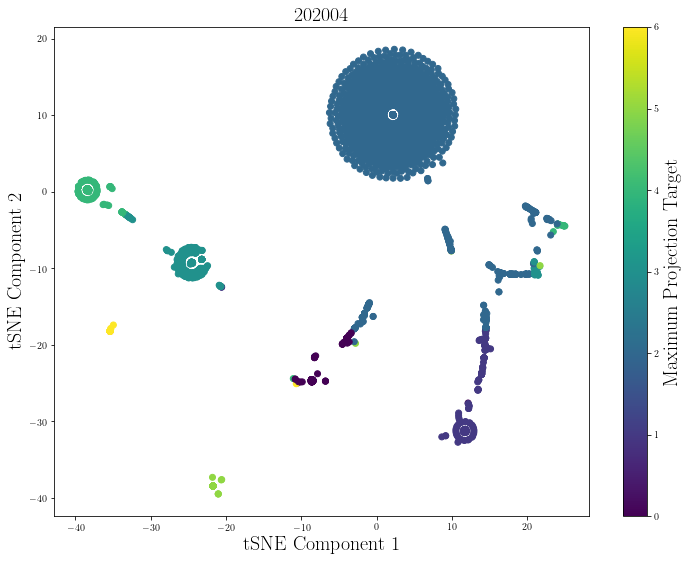

In [67]:
plt.figure(figsize=(12,9))
plt.title(save_name.replace('_',''),fontsize=20)
plt.xlabel("tSNE Component 1",fontsize=20)
plt.ylabel("tSNE Component 2",fontsize=20)
sc = plt.scatter(maxproj[:,0],maxproj[:,1],c=tlabels) #c=maxprojclusters[1]
cb = plt.colorbar(sc)
cb.set_label("Maximum Projection Target",fontsize=20)
plt.savefig(plot_dir + save_name + "_tsne.pdf")

## UpSet Plot

#### Preprocessing Functions

In [68]:
def prepare_upset_data(df):
    #mask1 = [i for (i,x) in enumerate(motif_labels) if len(x) > 1]
    mask1 = [i for (i,x) in enumerate(df['Degree'].to_list()) if x > 1]
    a = subset_list(df['Motifs'].to_list(), mask1)
    b = df['Observed'][mask1]
    c = df['Expected'][mask1]
    d = df['Expected SD'][mask1]
    e = df['Effect Size'][mask1]
    f = df['P-value'][mask1]
    g = df['Group'][mask1]
    mask2 = [i for i in range(b.shape[0]) if b.iloc[i] > 0]
    a = subset_list(a, mask2)
    b = b.iloc[mask2]
    b = b.to_numpy().astype(int)
    #
    c = c.iloc[mask2]
    c = c.to_numpy().astype(int)
    #
    d = d.iloc[mask2]
    #
    e = e.iloc[mask2]
    #
    f = f.iloc[mask2]
    #
    g = g.iloc[mask2]
    dfdata = pd.DataFrame(data=[a,b,c,d,e,f,g]).T
    dfdata.columns = ['Motifs', 'Observed', 'Expected', 'Expected SD', 'Effect Size', 'P-value', 'Group']
    #dfdata = dfdata.sort_values(by="Observed",ascending=False)
    return dfdata

In [69]:
sigsraw, slabelsraw = get_motif_sig_pts(dcounts,motif_labels,exclude_zeros=False, p_transform=lambda x:x)

In [70]:
effectsigsraw = np.array(sigsraw)
expected_sd_raw = np.array([np.sqrt(motif_probs[i] * n0 * (1-motif_probs[i])) for i in range(len(slabelsraw))])

In [71]:
degree = [len(x) for x in motif_labels]
degree[0] = 0

In [72]:
group = []
bonferroni_correction = len(slabels)
for i in range(len(degree)):
    """
    Group 1: motifs significantly over represented
    Group 2: motifs non-sig over-represented
    Group 3: motifs non-sig under-represented
    Group 4: motifs significantly under represented
    """
    grp = 0
    thr = 0.05 / bonferroni_correction
    if effectsigsraw[i,0] > 0: #over-represented
        if effectsigsraw[i,1] < thr: #statistically significant
            grp = 1
        else:
            grp = 3 #2
    else: #under-represented
        if effectsigsraw[i,1] > thr:
            grp = 4
        else: #statistically significant
            grp = 2
    group.append(grp)

In [73]:
dfraw = pd.DataFrame(data=[
                           motif_labels,\
                           dcounts,exp_counts.astype(int), \
                          expected_sd_raw,effectsigsraw[:,0], effectsigsraw[:,1], degree, group]).T
dfraw.columns=['Motifs','Observed','Expected', 'Expected SD','Effect Size', 'P-value', 'Degree', 'Group']

In [74]:
dfraw.to_csv("plots/dfraw.csv",index=None)

In [75]:
dfraw.iloc[40:70]
#54	[LS, BNST, LH]	14	11	3.41421	1.47675	0.000194429	3	1

,Motifs,Observed,Expected,Expected SD,Effect Size,P-value,Degree,Group
40,"[PFC, BNST, CeA]",0,4,2.09401,-2.43014,0.0270001,3,4
41,"[PFC, LH, BA]",0,4,2.09401,-2.43014,0.0270001,3,4
42,"[PFC, LH, CeA]",0,4,2.09401,-2.43014,0.0270001,3,4
43,"[PFC, BA, CeA]",0,4,2.09401,-2.43014,0.0270001,3,4
44,"[NAc, LS, BNST]",13,4,2.09401,1.37722,0.000638633,3,1
45,"[NAc, LS, LH]",5,4,2.09401,0.154823,0.633082,3,3
46,"[NAc, LS, BA]",5,4,2.09401,0.154823,0.633082,3,3
47,"[NAc, LS, CeA]",0,4,2.09401,-2.43014,0.0270001,3,4
48,"[NAc, BNST, LH]",1,4,2.09401,-1.43014,0.14443,3,4
49,"[NAc, BNST, BA]",2,4,2.09401,-0.845177,0.341199,3,4


In [76]:
dfdata = prepare_upset_data(dfraw)
dfdata = dfdata.sort_values(by=['Group','Observed'], ascending=[True,False])

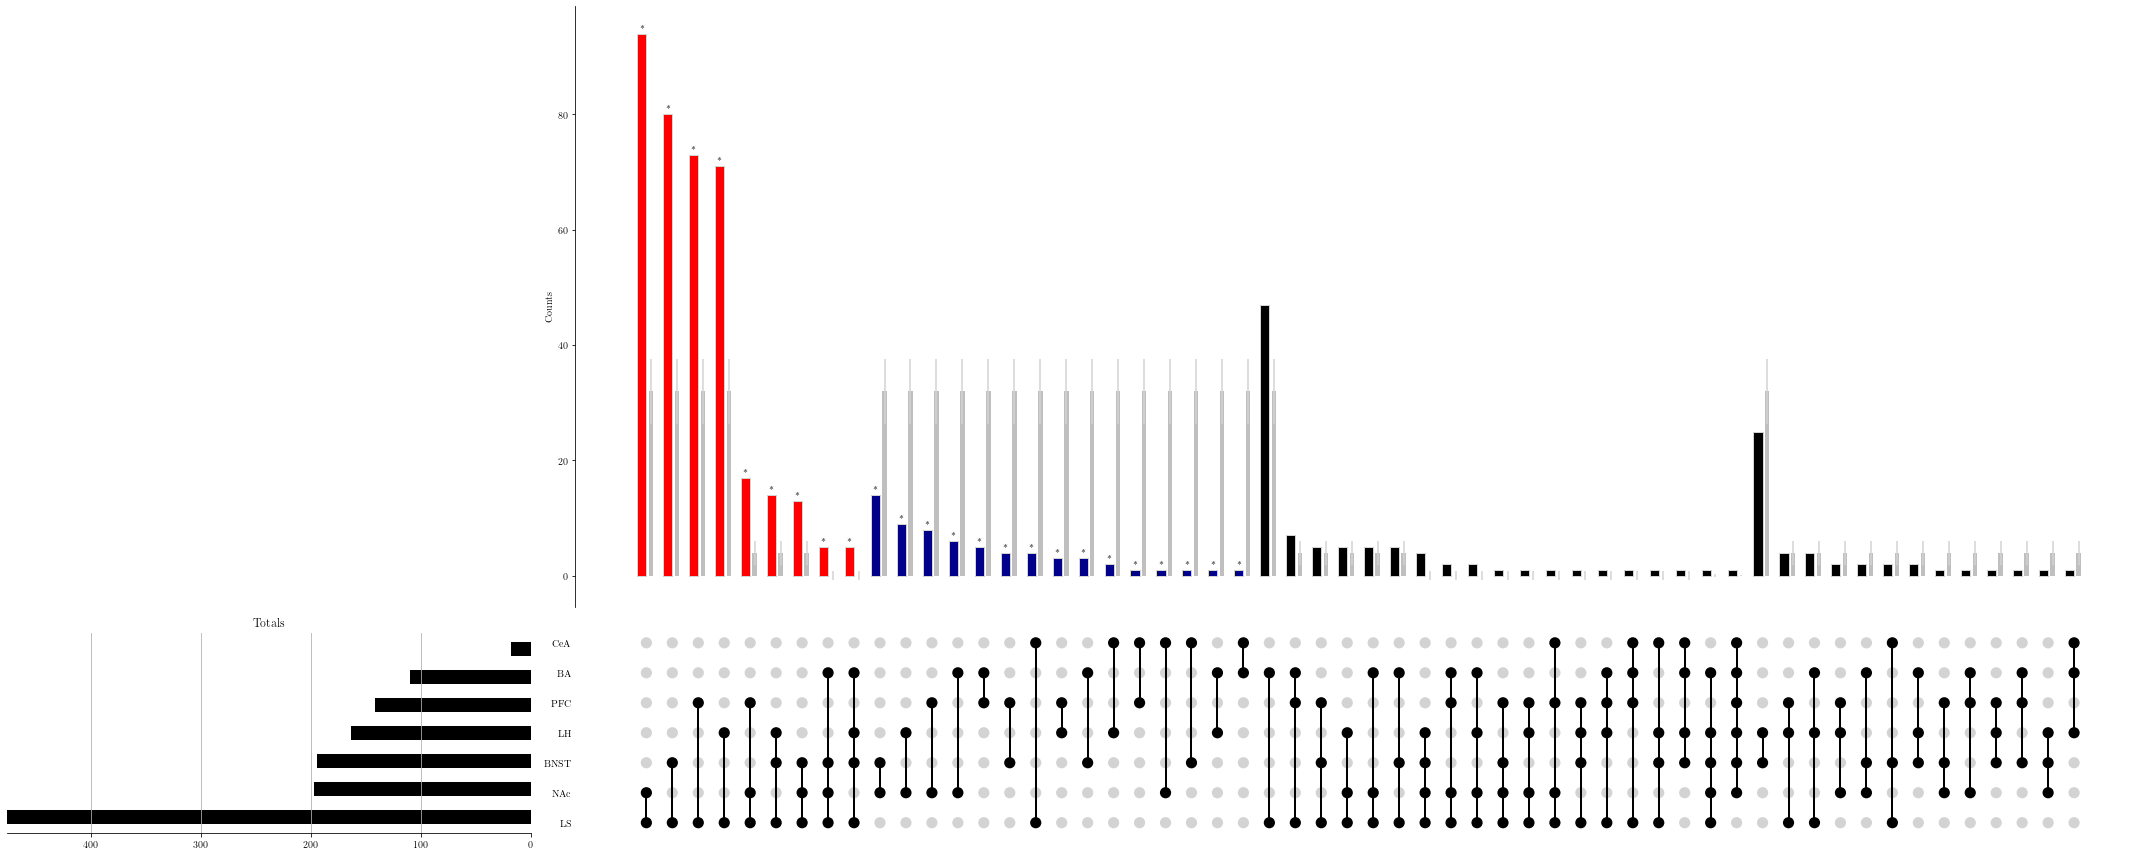

In [77]:
def kplot(df, size=(30,12)):
    """
    data : pd.DataFrame
    data is a dataframe with columns "Motifs" and "Counts"
    where "Motifs" is a list of lists e.g. [['PFC','LS'],['LS']]
    and "Counts" is a simple array of integers
    """
    motiflabels = df['Motifs'].to_list()
    data = up.from_memberships(motiflabels,data=df['Observed'].to_numpy())
    xlen = df.shape[0]
    xticks = np.arange(xlen)
    uplot = up.UpSet(data, sort_by=None) #sort_by='cardinality'
    fig,ax=plt.subplots(2,2,gridspec_kw={'width_ratios': [1, 3], 'height_ratios':[3,1]})
    fig.set_size_inches(size)
    ax[1,0].set_ylabel("Set Totals")
    uplot.plot_matrix(ax[1,1])
    uplot.plot_totals(ax[1,0])
    ax[0,0].axis('off')
    ax[0,1].spines['bottom'].set_visible(False)
    ax[0,1].spines['top'].set_visible(False)
    ax[0,1].spines['right'].set_visible(False)
    #ax[0,1].set_xticks([],[])
    width=0.35
    dodge=width/2
    x = np.arange(8)
    ax[1,0].set_title("Totals")
    ax[0,1].set_ylabel("Counts")
    #ax[0,1].set_xlim(-width,8)
    ax[0,1].set_xlim(ax[1,1].get_xlim())
    #ax[0,1].set_xticks(ax[1,1].get_xticks())
    ox = xticks-dodge
    ex = xticks+dodge
    #colorlist = ['cyan','darkgray','darkgray','red']
    colorlist = ['red','darkblue','black','black']
    cs = [colorlist[i-1] for i in df['Group']]
    ax[0,1].bar(ox,df['Observed'].to_numpy(),width=width,label="Observed", align="center",color=cs, edgecolor='lightgray')
    ax[0,1].bar(ex,df['Expected'].to_numpy(),yerr=df['Expected SD'].to_numpy(),width=width/2,label="Expected", align="center",color='gray',alpha=0.5,ecolor='lightgray')
    #draw group lines
    #g2 = np.where(dfdata['Group'].to_numpy() == 2)[0][0]
    #g4 = np.where(dfdata['Group'].to_numpy() == 4)[0][0]
    #ax[0,1].axvline(ex[g2]-1+1.5*dodge,color='black')
    #ax[0,1].axvline(ex[g4]-1+1.5*dodge,color='black')
    #add asterisks for significance
    grp_ = dfdata['Group'].to_numpy()
    idsig = np.concatenate([np.where(grp_ == 1)[0],np.where(grp_ == 2)[0]])
    [ax[0,1].text(ox[idsig][i]-0.5*dodge,df['Observed'].to_numpy()[idsig][i]+1,s="*") for i in range(idsig.shape[0])]
    # 
    ax[0,1].xaxis.grid(False)
    ax[0,1].xaxis.set_visible(False)
    ax[1,1].xaxis.set_visible(False)
    ax[1,1].xaxis.grid(False)
    #ax[0,1].legend()
    fig.tight_layout()
    return fig,ax

fig,_ = kplot(dfdata)

In [78]:
fig.savefig("plots/upsetplot.pdf",papertype='a4r')

In [ ]:
#LH-BNST-LS  is put as significant but overlaps with SD of expected
#LS+BNST+LH	1.476751	0.000194

In [79]:
df.astype(bool).sum()

PFC      229
NAc      316
LS      1734
BNST     424
LH       300
BA       171
CeA       46
dtype: int64